In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error
# Set a random seed for reproducibility
torch.manual_seed(42)

In [2]:
from differential_model import *
from generate_data import *
from physical_model import *
from plot import *

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")
device = torch.device("cpu")

GPU: NVIDIA GeForce GTX 1650 Ti


In [4]:
# System parameters
m = 1.0  # mass
c = 0.2  # damping coefficient
k = 100.0  # spring constant

# Time
t0 = 0
tf = 10

# Frequncy
fs = 50

# tspan
tspan = torch.arange(t0, tf, 1/fs)
nt = tf * fs

In [5]:
# Initialize the Spring_Model on the GPU
spring_model_gt = Spring_Model(m, c, k, t0, tf, fs, device, [1000, 3, 0, 2, 0])
simulator = Linear_Spring_Model(m, c, k, t0, tf, fs, device)

In [6]:
sig_u = [1, 3, 5]
data_gt = torch.zeros(nt, len(sig_u), 2)
data_simulated = torch.zeros(nt, len(sig_u), 2)
u_data = torch.zeros(nt, len(sig_u))

for i in range(len(sig_u)):
    u = generate_u(sig_u[i], nt, fs, device)
    data_gt[:, i, :] = generate_date(spring_model_gt, u).T
    data_simulated[:, i, :] = generate_date(simulator, u).T
    u_data[:, i] = u


In [7]:
initial_error = torch.mean((data_gt -data_simulated) ** 2)
initial_error

tensor(0.8543)

In [8]:
# Create a neural network model
model1 = NeuralNet(3, [16, 32, 16], 2, nn.ReLU(), device)
model1.load_state_dict(torch.load('linear_model_parameters_m1.pth'))
model2 = NeuralNet(3, [16, 32, 16], 1, nn.ReLU(), device)
model2.load_state_dict(torch.load('linear_model_epsilon_parameters_m1.pth'))
# Create a DifferentialSolver and train the model

<All keys matched successfully>

In [15]:

# Assuming you have the ground truth and simulated data
sig_u_test = np.linspace(0.1, 6.0, 10)  # Adjust the range and number of points as needed
ntest = 1250
data_gt_test = torch.zeros(ntest, len(sig_u_test), 2)
data_simulated_test = torch.zeros(ntest, len(sig_u_test), 2)
data_simulated_NN_test = torch.zeros(ntest, len(sig_u_test), 2)
u_data_test = torch.zeros(ntest, len(sig_u_test))
data_simulated_Epsilon_NN_test= torch.zeros(ntest, len(sig_u_test), 2)

# Arrays to store metrics
r2_simulated=torch.zeros(len(sig_u_test), 2)
RMSE_simulated =torch.zeros(len(sig_u_test), 2)
L2_simulated =torch.zeros(len(sig_u_test), 2)

r2_simulated_NN=torch.zeros(len(sig_u_test), 2)
RMSE_simulated_NN=torch.zeros(len(sig_u_test), 2)
L2_simulated_NN =torch.zeros(len(sig_u_test), 2)

r2_simulated_NN_epsilon=torch.zeros(len(sig_u_test), 2)
RMSE_simulated_NN_epsilon=torch.zeros(len(sig_u_test), 2)
L2_simulated_NN_epsilon =torch.zeros(len(sig_u_test), 2)

for i in range(len(sig_u_test)):
    u = generate_u(sig_u_test[i], ntest, fs, device)
    data_gt_test[:, i, :] = generate_date(spring_model_gt, u).T
    data_simulated_test[:, i, :] = generate_date(simulator, u).T
    u_data_test[:, i] = u

    yi = data_simulated_NN_test[0, :].T
    for m in range(ntest - 1):
        u_m = u_data_test[m : m + 1, :]
        yi = simulator.step(yi, u_m)
        input_data = torch.cat([u_m, yi], axis=0).T
        dy_i = model1(input_data).T
        yi = yi + dy_i
        data_simulated_NN_test[m + 1, :] = yi.T

    yi_epsilon = data_simulated_Epsilon_NN_test[0, :].T
    for m in range(ntest - 1):
        u_m_epsilon = u_data_test[m : m + 1, :] # torch.Size([1, 5])
        yi_epsilon = simulator.step(yi_epsilon, u_m_epsilon)
        input = torch.cat([u_m_epsilon, yi_epsilon], axis=0).T  # Concatenate k and yi.T
        epsilon = model2(input).T # torch.Size([2, 5])
        dy_i_epsilon = simulator.step_model(epsilon=epsilon)
        yi_epsilon = yi_epsilon + dy_i_epsilon
        data_simulated_Epsilon_NN_test[m + 1, :] = yi_epsilon.T     
    
    
    gt=data_gt_test[:, i, :].cpu().numpy()
    simulated=data_simulated_test[:, i, :].cpu().detach().numpy()
    simulated_NN = data_simulated_NN_test[:, i, :].cpu().detach().numpy()
    simulated_NN_epsilon= data_simulated_Epsilon_NN_test[:, i, :].cpu().detach().numpy()
    # Calculate R2 score
     # Calculate R2 score
    r2_simulated[i][0],r2_simulated[i][1] = torch.tensor(r2_score(gt[:, 0], simulated[:, 0]), dtype=torch.float32),torch.tensor(r2_score(gt[:, 1], simulated[:, 1]), dtype=torch.float32)
    r2_simulated_NN[i][0], r2_simulated_NN[i][1]= torch.tensor(r2_score(gt[:, 0], simulated_NN[:, 0]), dtype=torch.float32), torch.tensor(r2_score(gt[:, 1], simulated_NN[:, 1]), dtype=torch.float32)
    r2_simulated_NN_epsilon[i][0],r2_simulated_NN_epsilon[i][1]=torch.tensor(r2_score(gt[:, 0], simulated_NN_epsilon[:, 0]), dtype=torch.float32), torch.tensor(r2_score(gt[:, 1], simulated_NN_epsilon[:, 1]), dtype=torch.float32)

    # Calculate RMSE (Root Mean Squared Error)
    RMSE_simulated[i][0],RMSE_simulated[i][1] = torch.tensor(mean_squared_error(gt[:, 0], simulated[:, 0], squared=False), dtype=torch.float32), torch.tensor(mean_squared_error(gt[:, 1], simulated[:, 1], squared=False), dtype=torch.float32)
    RMSE_simulated_NN[i][0],RMSE_simulated_NN[i][1] = torch.tensor(mean_squared_error(gt[:, 0], simulated_NN[:, 0], squared=False), dtype=torch.float32), torch.tensor(mean_squared_error(gt[:, 1], simulated_NN[:, 1], squared=False), dtype=torch.float32)
    RMSE_simulated_NN_epsilon[i][0],RMSE_simulated_NN_epsilon[i][1] = torch.tensor(mean_squared_error(gt[:, 0], simulated_NN_epsilon[:, 0], squared=False), dtype=torch.float32), torch.tensor(mean_squared_error(gt[:, 1], simulated_NN_epsilon[:, 1], squared=False), dtype=torch.float32)

    # Calculate L2 loss
    L2_simulated[i][0], L2_simulated[i][1] = torch.tensor(((gt[:, 0] - simulated[:, 0]) ** 2).sum(), dtype=torch.float32), torch.tensor(((gt[:, 1] - simulated[:, 1]) ** 2).sum(), dtype=torch.float32)
    L2_simulated_NN[i][0], L2_simulated_NN[i][1]  = torch.tensor(((gt[:, 0] - simulated_NN[:, 0]) ** 2).sum(), dtype=torch.float32),  torch.tensor(((gt[:, 1] - simulated_NN[:, 1]) ** 2).sum(), dtype=torch.float32)
    L2_simulated_NN_epsilon[i][0], L2_simulated_NN_epsilon[i][1]  = torch.tensor(((gt[:, 0] - simulated_NN_epsilon[:, 0]) ** 2).sum(), dtype=torch.float32),  torch.tensor(((gt[:, 1] - simulated_NN_epsilon[:, 1]) ** 2).sum(), dtype=torch.float32)


In [16]:
# Calculate standard deviation for R2, RMSE, and L2
std_r2_simulated = torch.std(r2_simulated, dim=0)
std_rmse_simulated = torch.std(RMSE_simulated, dim=0)
std_l2_simulated = torch.std(L2_simulated, dim=0)

std_r2_simulated_NN = torch.std(r2_simulated_NN, dim=0)
std_rmse_simulated_NN = torch.std(RMSE_simulated_NN, dim=0)
std_l2_simulated_NN = torch.std(L2_simulated_NN, dim=0)

std_r2_simulated_NN_epsilon = torch.std(r2_simulated_NN_epsilon, dim=0)
std_rmse_simulated_NN_epsilon = torch.std(RMSE_simulated_NN_epsilon, dim=0)
std_l2_simulated_NN_epsilon = torch.std(L2_simulated_NN_epsilon, dim=0)

# Display the results with mean and standard deviation
print(f"Total R2 for Simulated: {total_r2_simulated.numpy()} +- {std_r2_simulated.numpy()}")
print(f"Total RMSE for Simulated: {total_rmse_simulated.numpy()} +- {std_rmse_simulated.numpy()}")
print(f"Total L2 for Simulated: {total_l2_simulated.numpy()} +- {std_l2_simulated.numpy()}")

print(f"Total R2 for Simulated NN: {total_r2_simulated_NN.numpy()} +- {std_r2_simulated_NN.numpy()}")
print(f"Total RMSE for Simulated NN: {total_rmse_simulated_NN.numpy()} +- {std_rmse_simulated_NN.numpy()}")
print(f"Total L2 for Simulated NN: {total_l2_simulated_NN.numpy()} +- {std_l2_simulated_NN.numpy()}")

print(f"Total R2 for Simulated NN Epsilon: {total_r2_simulated_NN_epsilon.numpy()} +- {std_r2_simulated_NN_epsilon.numpy()}")
print(f"Total RMSE for Simulated NN Epsilon: {total_rmse_simulated_NN_epsilon.numpy()} +- {std_rmse_simulated_NN_epsilon.numpy()}")
print(f"Total L2 for Simulated NN Epsilon: {total_l2_simulated_NN_epsilon.numpy()} +- {std_l2_simulated_NN_epsilon.numpy()}")


NameError: name 'total_r2_simulated' is not defined

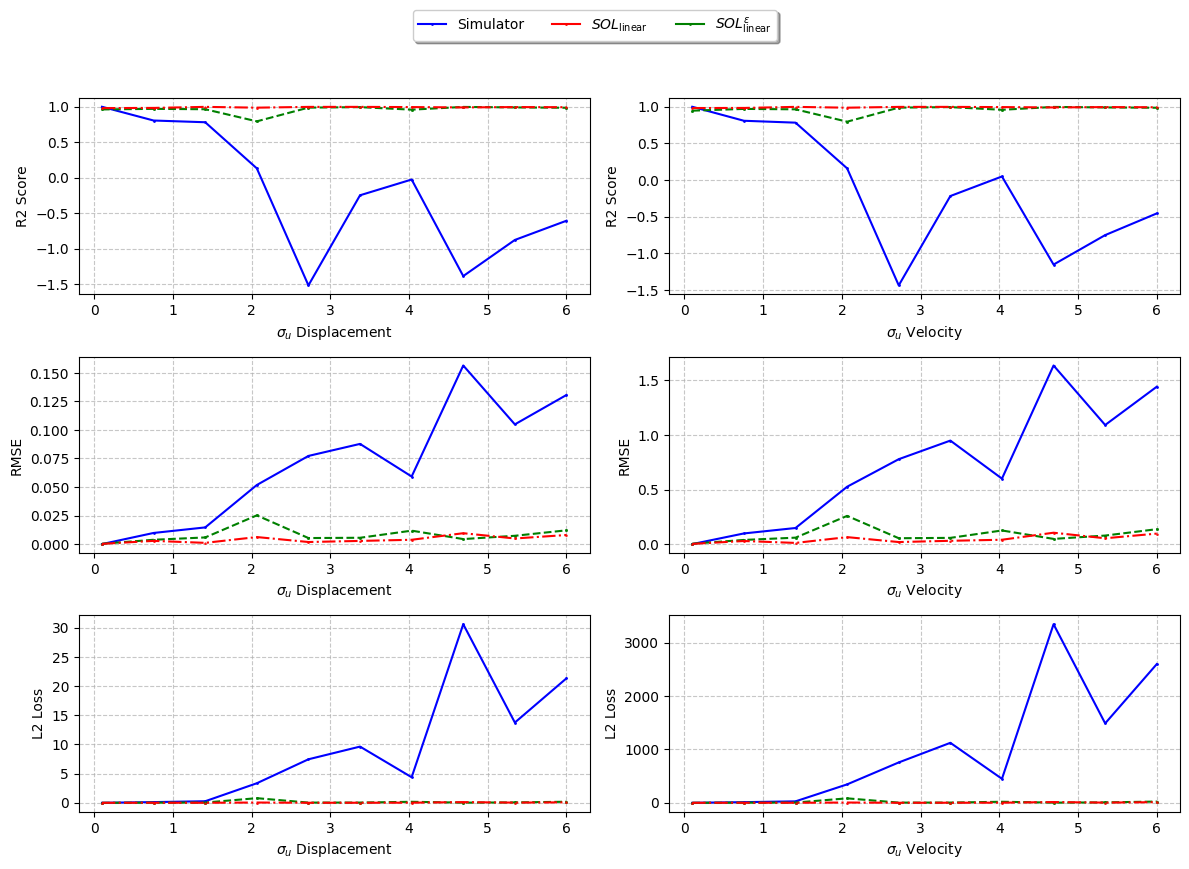

In [17]:
import matplotlib.pyplot as plt

# Function to beautify the plots
def beautify_plot(title, ylabel, val):
    plt.xlabel('$\sigma_u$ ' + val)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.7)
    # plt.legend()
    plt.tight_layout()

# Plotting the R2, RMSE, L2 loss against sig_u_test for displacement and velocity
plt.figure(figsize=(12, 16))
marker_size=1
# Section 1: Displacement
plt.subplot(6, 2, 1)
plt.plot(sig_u_test, r2_simulated[:, 0], marker='o', linestyle='-', color='b', label='R2_simulated', markersize=marker_size)
plt.plot(sig_u_test, r2_simulated_NN[:, 0], marker='s', linestyle='--', color='g', label='R2_simulated_NN', markersize=marker_size)
plt.plot(sig_u_test, r2_simulated_NN_epsilon[:, 0], marker='^', linestyle='-.', color='r', label='R2_simulated_NN_epsilon', markersize=marker_size)
beautify_plot('R2 Scores vs $\sigma_u$', 'R2 Score', 'Displacement')

plt.subplot(6, 2, 3)
plt.plot(sig_u_test, RMSE_simulated[:, 0], marker='o', linestyle='-', color='b', label='RMSE_simulated', markersize=marker_size)
plt.plot(sig_u_test, RMSE_simulated_NN[:, 0], marker='s', linestyle='--', color='g', label='RMSE_simulated_NN', markersize=marker_size)
plt.plot(sig_u_test, RMSE_simulated_NN_epsilon[:, 0], marker='^', linestyle='-.', color='r', label='RMSE_simulated_NN_epsilon', markersize=marker_size)
beautify_plot('RMSE vs $\sigma_u$', 'RMSE', 'Displacement')

plt.subplot(6, 2, 5)
plt.plot(sig_u_test, L2_simulated[:, 0], marker='o', linestyle='-', color='b', label='L2_simulated', markersize=marker_size)
plt.plot(sig_u_test, L2_simulated_NN[:, 0], marker='s', linestyle='--', color='g', label='L2_simulated_NN', markersize=marker_size)
plt.plot(sig_u_test, L2_simulated_NN_epsilon[:, 0], marker='^', linestyle='-.', color='r', label='L2_simulated_NN_epsilon', markersize=marker_size)
beautify_plot('L2 Loss vs $\sigma_u$', 'L2 Loss', 'Displacement')

# Section 2: Velocity
plt.subplot(6, 2, 2)
plt.plot(sig_u_test, r2_simulated[:, 1], marker='o', linestyle='-', color='b', label='R2_simulated', markersize=marker_size)
plt.plot(sig_u_test, r2_simulated_NN[:, 1], marker='s', linestyle='--', color='g', label='R2_simulated_NN', markersize=marker_size)
plt.plot(sig_u_test, r2_simulated_NN_epsilon[:, 1], marker='^', linestyle='-.', color='r', label='R2_simulated_NN_epsilon', markersize=marker_size)
beautify_plot('R2 Scores vs $\sigma_u$', 'R2 Score', 'Velocity')

plt.subplot(6, 2, 4)
plt.plot(sig_u_test, RMSE_simulated[:, 1], marker='o', linestyle='-', color='b', label='RMSE_simulated', markersize=marker_size)
plt.plot(sig_u_test, RMSE_simulated_NN[:, 1], marker='s', linestyle='--', color='g', label='RMSE_simulated_NN', markersize=marker_size)
plt.plot(sig_u_test, RMSE_simulated_NN_epsilon[:, 1], marker='^', linestyle='-.', color='r', label='RMSE_simulated_NN_epsilon', markersize=marker_size)
beautify_plot('RMSE vs $\sigma_u$', 'RMSE', 'Velocity')

plt.subplot(6, 2, 6)
plt.plot(sig_u_test, L2_simulated[:, 1], marker='o', linestyle='-', color='b', label='L2_simulated', markersize=marker_size)
plt.plot(sig_u_test, L2_simulated_NN[:, 1], marker='s', linestyle='--', color='g', label='L2_simulated_NN', markersize=marker_size)
plt.plot(sig_u_test, L2_simulated_NN_epsilon[:, 1], marker='^', linestyle='-.', color='r', label='L2_simulated_NN_epsilon', markersize=marker_size)
beautify_plot('L2 Loss vs $\sigma_u$', 'L2 Loss', 'Velocity')

# Create a box at the top for colored labels
# handles, labels = plt.gca().get_legend_handles_labels()
# figlegend = plt.figlegend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1.15))
plt.figlegend(handles=[plt.Line2D([0], [0], marker='o', color='b', markerfacecolor='b', markersize=marker_size),
                      plt.Line2D([0], [0], marker='o', color='r', markerfacecolor='g', markersize=marker_size),
                      plt.Line2D([0], [0], marker='o', color='g', markerfacecolor='r', markersize=marker_size)],
              labels = ['Simulator', r'$SOL_{\mathrm{linear}}$', r'$SOL_{\mathrm{linear}}^{\epsilon}$'],
              loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

# Adjust layout to make space for the legend box
plt.tight_layout(rect=[0, 0.15, 1, 1.1])
plt.show()


In [18]:
initial_error_test = torch.mean((data_gt_test -data_simulated_test) ** 2)
final_error_test = torch.mean((data_gt_test -data_simulated_NN_test) ** 2)
final_epsilon_error_test= torch.mean((data_gt_test - data_simulated_Epsilon_NN_test) ** 2)
initial_error_test, final_error_test, final_epsilon_error_test

(tensor(0.4097),
 tensor(0.0061, grad_fn=<MeanBackward0>),
 tensor(0.0015, grad_fn=<MeanBackward0>))

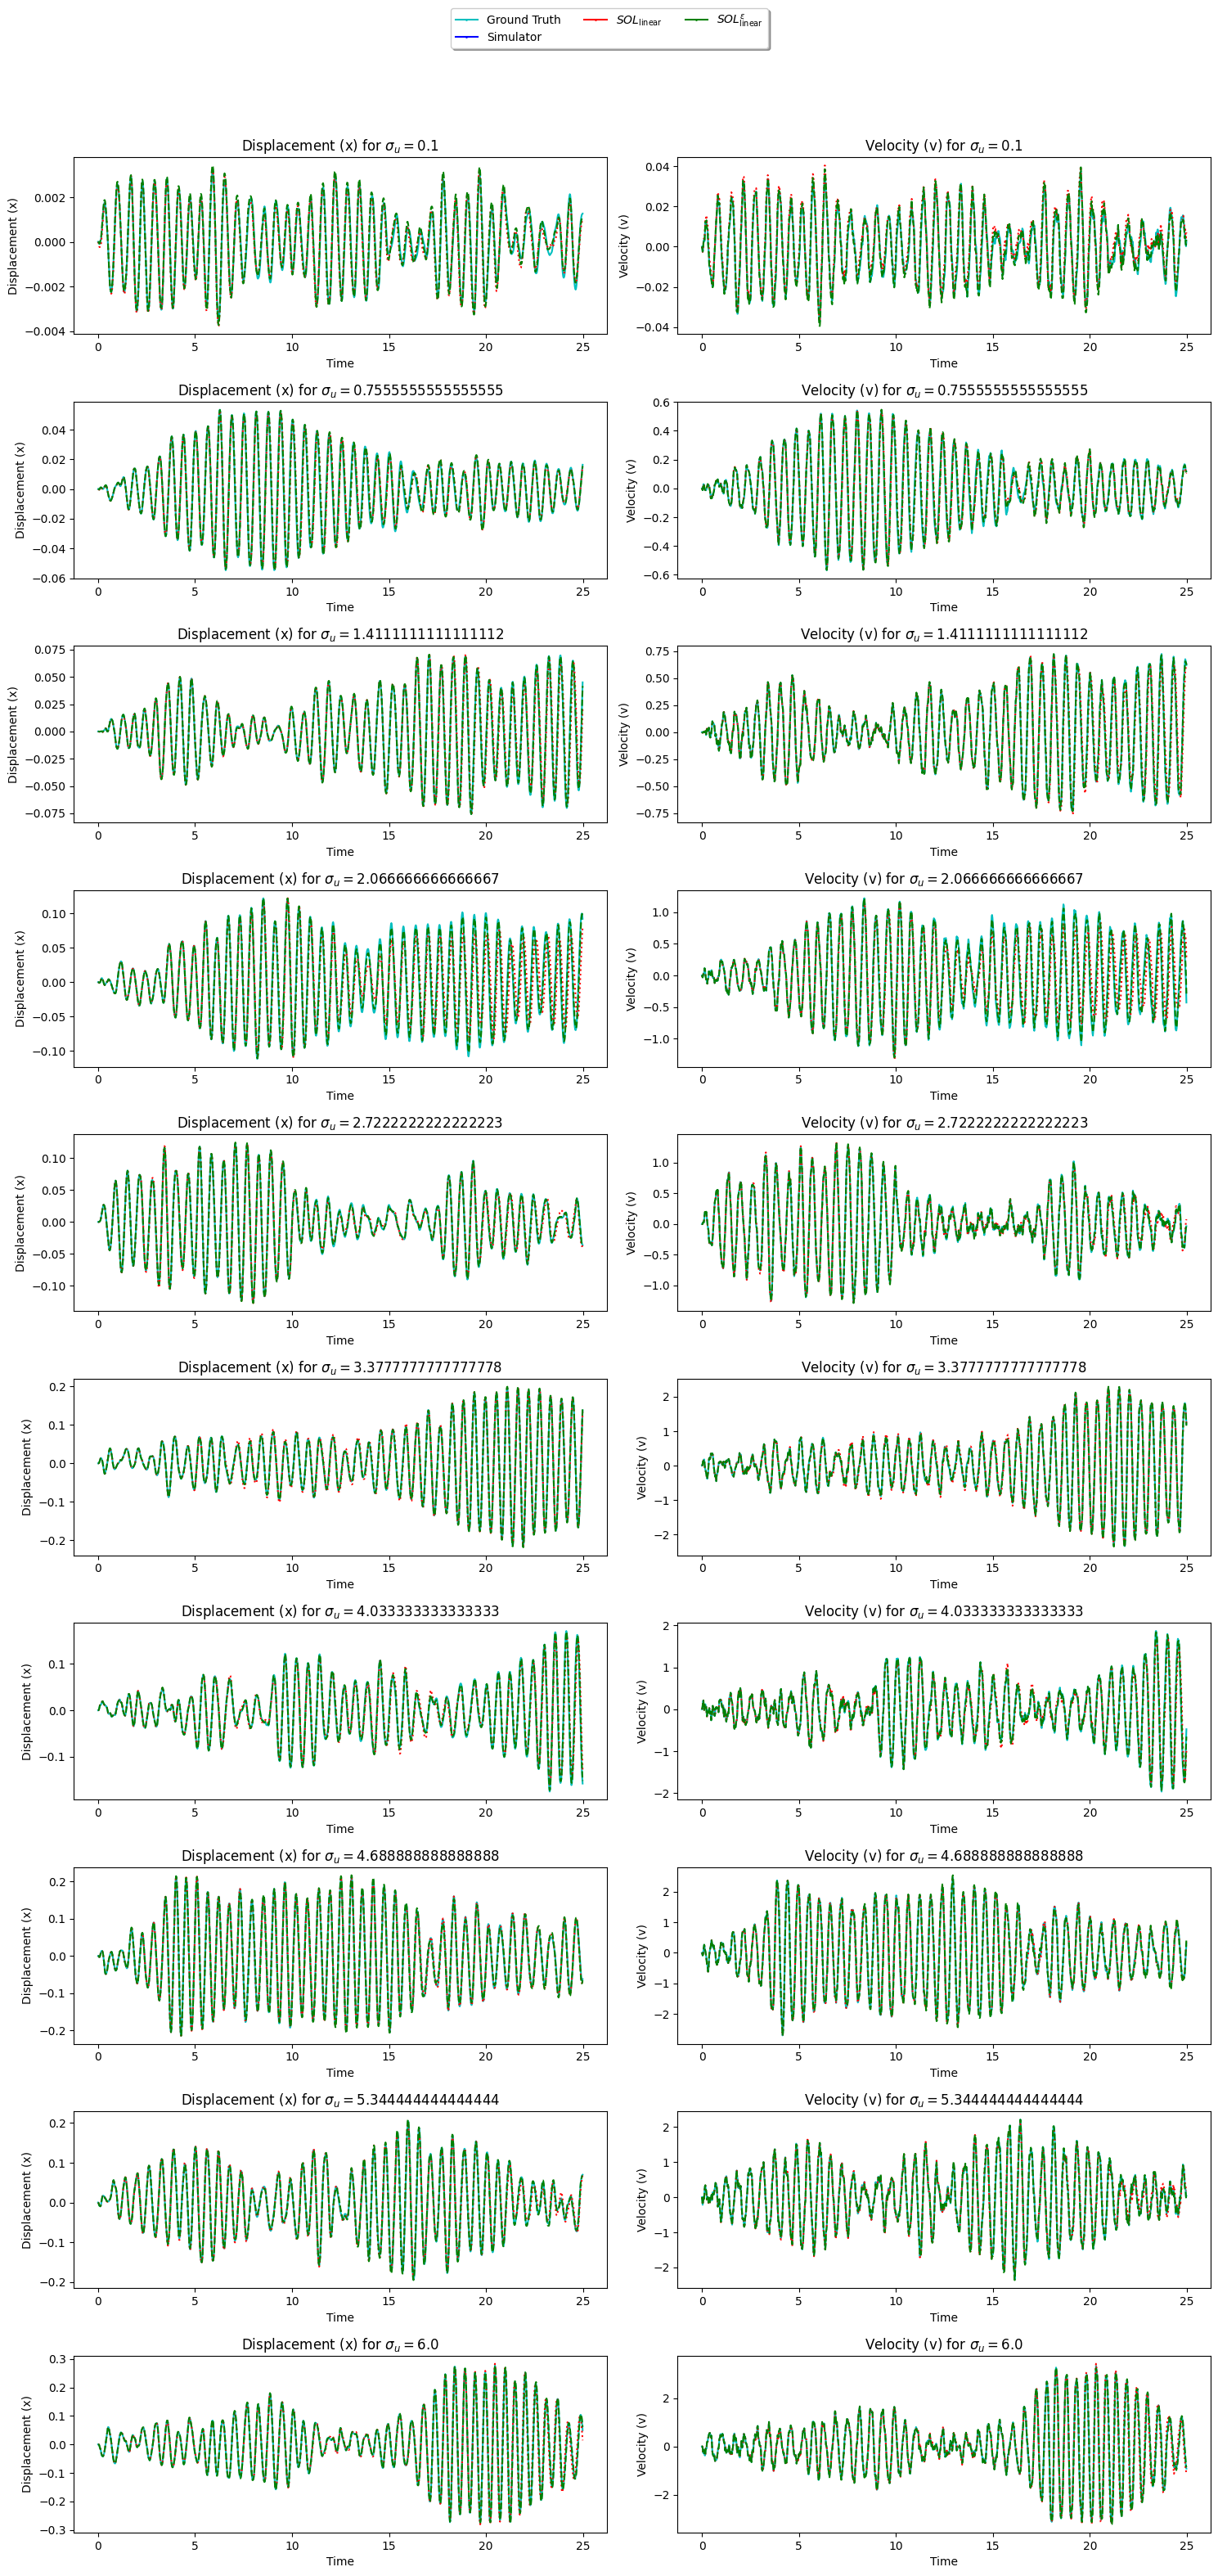

In [19]:
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Function to adjust the overall figure size and create a box legend
def adjust_and_legend():
    plt.figure(figsize=(15, 3 * len(sig_u_test)))


# Plotting
tspan_test = torch.arange(t0, t0 + ntest/fs, 1/fs)
time_values = tspan_test.squeeze().cpu().numpy()

# Adjust the overall figure size
adjust_and_legend()

for i in range(len(sig_u_test)):
    # Subplots with reduced size
    plt.subplot(len(sig_u_test), 2, 2 * i + 1)
    plt.plot(time_values, data_gt_test[:, i, 0], linestyle='-', color='c')
    # plt.plot(time_values, data_simulated_test[:, i, 0], linestyle='--', color='b')
    plt.plot(time_values, data_simulated_NN_test.detach().numpy()[:, i, 0], linestyle=':', color='r')
    plt.plot(time_values, data_simulated_Epsilon_NN_test.detach().numpy()[:, i, 0], linestyle='--', color='g')

    plt.xlabel('Time')
    plt.ylabel('Displacement (x)')
    plt.title(f'Displacement (x) for $\\sigma_{{u}}={sig_u_test[i]}$')

    plt.subplot(len(sig_u_test), 2, 2 * i + 2)
    plt.plot(time_values, data_gt_test[:, i, 1], linestyle='-', color='c')
    # plt.plot(time_values, data_simulated_test[:, i, 1], linestyle='--', color='b')
    plt.plot(time_values, data_simulated_NN_test.detach().numpy()[:, i, 1], linestyle=':', color='r')
    plt.plot(time_values, data_simulated_Epsilon_NN_test.detach().numpy()[:, i, 1], linestyle='--', color='g')

    plt.xlabel('Time')
    plt.ylabel('Velocity (v)')
    plt.title(f'Velocity (v) for $\\sigma_{{u}}={sig_u_test[i]}$')

# Manually add legend entries for the box legend
plt.figlegend(handles=[plt.Line2D([0], [0], marker='o', color='c', markerfacecolor='c', markersize=marker_size),
                       plt.Line2D([0], [0], marker='o', color='b', markerfacecolor='b', markersize=marker_size),
                       plt.Line2D([0], [0], marker='o', color='r', markerfacecolor='r', markersize=marker_size),
                       plt.Line2D([0], [0], marker='o', color='g', markerfacecolor='g', markersize=marker_size)],
              labels = ['Ground Truth','Simulator', r'$SOL_{\mathrm{linear}}$', r'$SOL_{\mathrm{linear}}^{\epsilon}$'],
              loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)
plt.tight_layout(rect=[0, 0.1, 1, 1.1])
plt.show()
